# Improving accuracy with Fine-Tuning

Many of the pre-trained models were trained on the ImageNet dataset. Therefore, they provide an incredible starting point for similarity computations in most situations.

We will find the least accurate (worst) performing categories, visualize them with t-SNE, fine-tune and see how their t-SNE graph changes. 

In [1]:
import numpy as np
import pickle
from tqdm import tqdm, notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
from textwrap import wrap

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib notebook

In [2]:
def classname(str):
    return str.split('/')[-2]

Helper function to display accuracy stats and plot similar images

In [3]:
def display(dic, per_class, neighbors, message):
    for key in dic:
        print(key, "\tAccuracy: ", per_class[key])
    for each_class in dic:
        indices_of_class = [
            i for i, j in enumerate(filenames) if classname(j) == each_class]
        random_image_index = random.choice(indices_of_class)
        distances, indices = neighbors.kneighbors(
            [feature_list[random_image_index]])
        similar_image_paths = [filenames[random_image_index]] + \
            [filenames[indices[0][i]] for i in range(1, 4)]
        plot_images(similar_image_paths, distances[0], message)

Helper function that calculates accuracy using the Nearest Neighbors Brute force algorithm and returns the classes that the model performed least accurately on. 

In [4]:
def get_least_accurate_classes(feature_list):
    per_class_acc = {}
    num_nearest_neighbors = 5
    num_correct_predictions = 0
    num_incorrect_predictions = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    for i in notebook.tqdm(range(len(feature_list))):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            predicted_class = classname(filenames[indices[0][j]])
            ground_truth = classname(filenames[i])
            if (predicted_class not in per_class_acc):
                per_class_acc[predicted_class] = [0, 0, 0]
            if ground_truth == predicted_class:
                num_correct_predictions += 1
                per_class_acc[predicted_class][0] += 1
                per_class_acc[predicted_class][2] += 1
            else:
                num_incorrect_predictions += 1
                per_class_acc[predicted_class][1] += 1
                per_class_acc[predicted_class][2] += 1
    print(
        "Accuracy is ",
        round(
            100.0 * num_correct_predictions /
            (1.0 * num_correct_predictions + num_incorrect_predictions), 2))
    for key, value in per_class_acc.items():
        per_class_acc[key] = round(100.0 * value[0] / (1.0 * value[2]), 2)
    dic = sorted(per_class_acc, key=per_class_acc.get)

    # least_accurate classes
    print("\n\nTop 10 incorrect classifications\n")
    for key in dic[:10]:
        print(key, "\tAccuracy: ", per_class_acc[key])
    return dic[:6], per_class_acc

Load the features of the Caltech101 dataset to run our experiments on. 

In [5]:
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-resnet.pickle', 'rb'))
class_ids = pickle.load(open('data/class_ids-caltech101.pickle', 'rb'))

Train the PCA model on the loaded features. 

In [6]:
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list = pca.transform(feature_list)

In [7]:
names_of_least_accurate_classes_before_finetuning, accuracy_per_class_before_finetuning = get_least_accurate_classes(feature_list[:])

  0%|          | 0/8677 [00:00<?, ?it/s]

Accuracy is  88.64


Top 10 incorrect classifications

lobster 	Accuracy:  48.94
water_lilly 	Accuracy:  50.28
anchor 	Accuracy:  50.69
crocodile 	Accuracy:  52.2
bass 	Accuracy:  58.08
crocodile_head 	Accuracy:  58.75
schooner 	Accuracy:  60.34
crayfish 	Accuracy:  61.19
octopus 	Accuracy:  61.96
garfield 	Accuracy:  63.16


Print names of the least accurate classes before fine-tuning

In [8]:
names_of_least_accurate_classes_before_finetuning

['lobster', 'water_lilly', 'anchor', 'crocodile', 'bass', 'crocodile_head']

Combine the features from the 6 least accurate classes into a list so that we can use this list for further experiments and visualization. 

In [9]:
least_accurate_feature_list = []
least_accurate_filenames = []
least_accurate_count = {}
for index, filename in enumerate(filenames):
    if classname(filename) not in least_accurate_count:
        least_accurate_count[classname(filename)] = 0
    if classname(
            filename
    ) in names_of_least_accurate_classes_before_finetuning and least_accurate_count[
            classname(filename)] <= 50:
        least_accurate_feature_list.append(feature_list[index])
        least_accurate_count[classname(filename)] += 1
        least_accurate_filenames.append(class_ids[index])

Train t-SNE only on the 6 least accurate classes.

In [10]:
from sklearn.manifold import TSNE
import numpy as np

selected_features = np.array(least_accurate_feature_list)
selected_class_ids = least_accurate_filenames
selected_filenames = least_accurate_filenames
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, metric='euclidean')
tsne_results = tsne.fit_transform(selected_features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 272 samples in 0.000s...
[t-SNE] Computed neighbors for 272 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 272 / 272
[t-SNE] Mean sigma: 0.198108
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.640541
[t-SNE] KL divergence after 1000 iterations: 0.556741
t-SNE done! Time elapsed: 0.9727699756622314 seconds


## t-SNE visualization of feature vectors of least accurate classes before finetuning

<IPython.core.display.Javascript object>


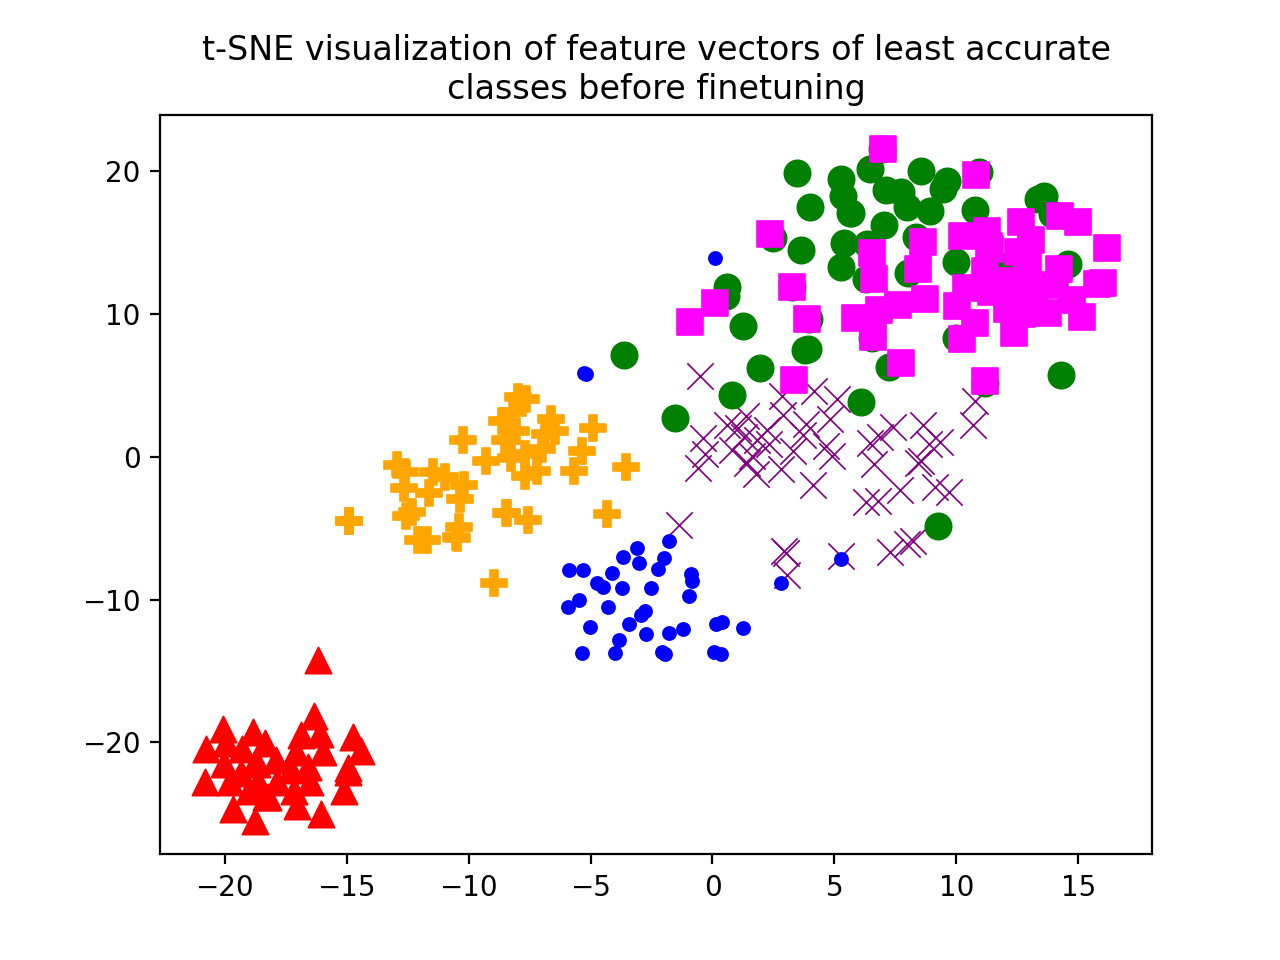

In [11]:
import matplotlib.pyplot as plt
from textwrap import wrap

plt.title("\n".join(wrap("t-SNE visualization of feature vectors of least accurate classes before finetuning", 60)))
set_classes = list(set(selected_class_ids))
markers = ["^", ".", "s", "o", "x", "P"]
colors = ['red', 'blue', 'fuchsia', 'green', 'purple', 'orange']
class_to_marker = {}
class_to_color = {}

for index in range(len(tsne_results)):
    if selected_class_ids[index] not in class_to_marker:
        class_to_marker[selected_class_ids[index]] = markers.pop()
    if selected_class_ids[index] not in class_to_color:
        class_to_color[selected_class_ids[index]] = colors.pop()
    
    plt.scatter(tsne_results[index, 0],
                tsne_results[index, 1],
                c=class_to_color[selected_class_ids[index]],
                marker=class_to_marker[selected_class_ids[index]],
                linewidths=0.6,  # Use linewidths instead of linewidth
                s=90)

plt.show()

In [12]:
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-resnet.pickle', 'rb'))
class_ids = pickle.load(open('data/class_ids-caltech101.pickle', 'rb'))

In [13]:
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list = pca.transform(feature_list)

In [14]:
least_accurate_feature_list = []
least_accurate_filenames = []
least_accurate_count = {}
for index, filename in enumerate(filenames):
    if classname(filename) not in least_accurate_count:
        least_accurate_count[classname(filename)] = 0
    if classname(
            filename
    ) in names_of_least_accurate_classes_before_finetuning and least_accurate_count[
            classname(filename)] <= 50:
        least_accurate_feature_list.append(feature_list[index])
        least_accurate_count[classname(filename)] += 1
        least_accurate_filenames.append(class_ids[index])

In [15]:
from sklearn.manifold import TSNE
import numpy as np

selected_features = np.array(least_accurate_feature_list)
selected_class_ids = least_accurate_filenames
selected_filenames = least_accurate_filenames
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, metric='euclidean')
tsne_results = tsne.fit_transform(selected_features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 272 samples in 0.000s...
[t-SNE] Computed neighbors for 272 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 272 / 272
[t-SNE] Mean sigma: 0.197682
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.370300
[t-SNE] KL divergence after 1000 iterations: 0.568697
t-SNE done! Time elapsed: 0.9587087631225586 seconds


## t-SNE visualization of feature vectors of least accurate classes after finetuning

<IPython.core.display.Javascript object>


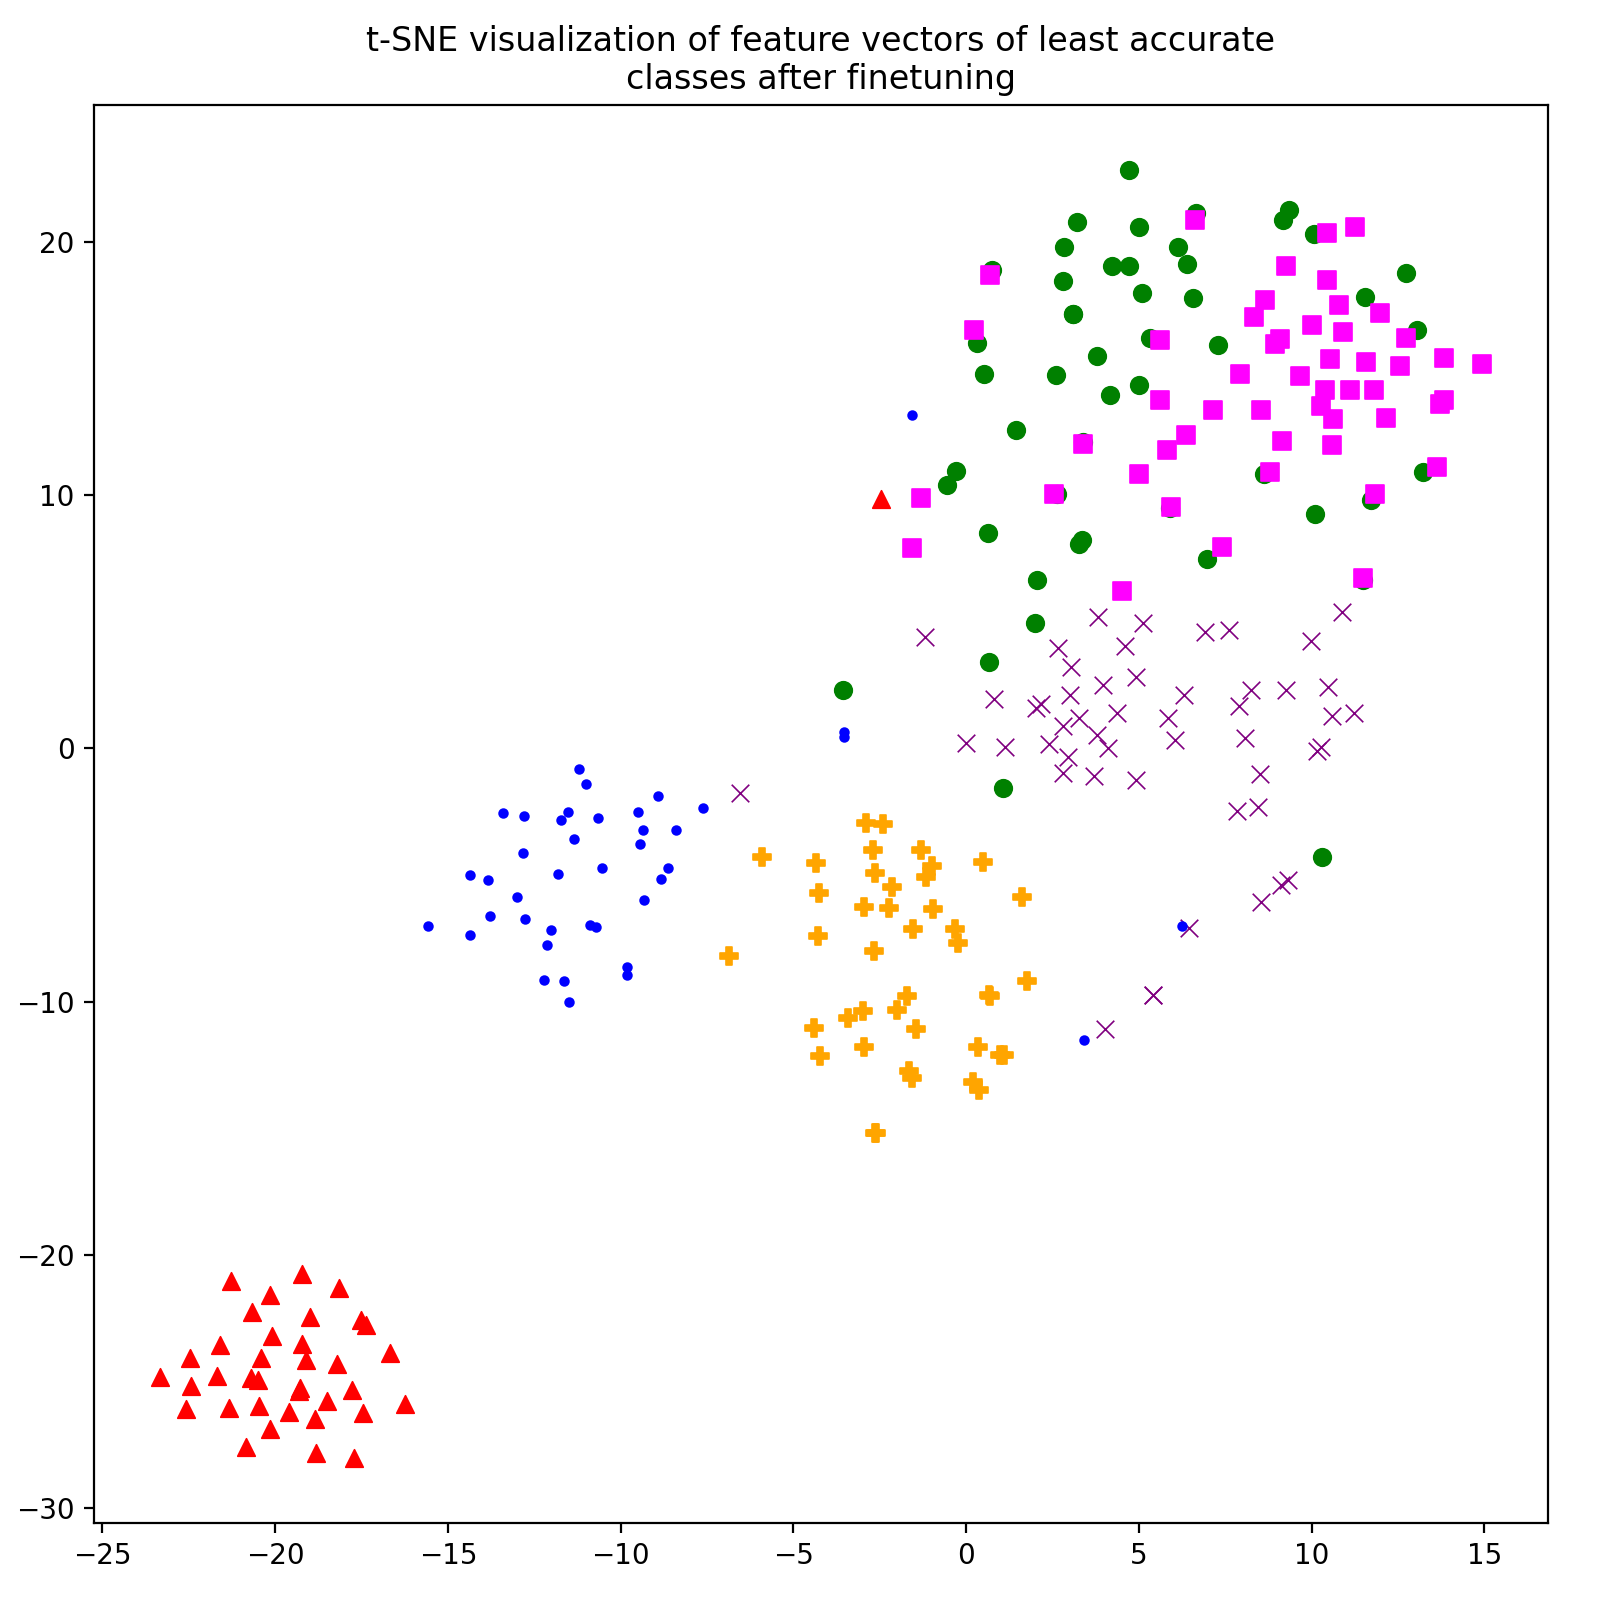

In [16]:
import matplotlib.pyplot as plt
from textwrap import wrap

plt.figure(figsize=(8, 8))  # Set the figure size as desired
plt.title("\n".join(wrap("t-SNE visualization of feature vectors of least accurate classes after finetuning", 60)))
plt.tight_layout()

set_classes = list(set(selected_class_ids))
markers = ["^", ".", "s", "o", "x", "P"]
colors = ['red', 'blue', 'fuchsia', 'green', 'purple', 'orange']
class_to_marker = {}
class_to_color = {}

for index in range(len(tsne_results)):
    if selected_class_ids[index] not in class_to_marker:
        class_to_marker[selected_class_ids[index]] = markers.pop()
    if selected_class_ids[index] not in class_to_color:
        class_to_color[selected_class_ids[index]] = colors.pop()

    scatterPlot = plt.scatter(
        tsne_results[index, 0],
        tsne_results[index, 1],
        c=class_to_color[selected_class_ids[index]],
        marker=class_to_marker[selected_class_ids[index]],
        linewidth=0.6,
        s=40  # Adjust the marker size as desired
    )

plt.show()